## Statistické příznaky z časových řad (např. akcelerometr)
Tento přístup se řadí mezi ručně definované (engineered) příznaky, které extrahujeme z časových řad pomocí základních statistických operací jako průměr, směrodatná odchylka, maximum, minimum apod. V kontextu dat z akcelerometru či gyroskopu je taková extrakce velmi výhodná – umožňuje převést sekvenci (např. 1 sekundu měření) do pevně strukturovaného vektoru příznaků, který je vhodný pro klasické algoritmy strojového učení (např. SVM, Random Forest). Statistické příznaky bývají levné na výpočet, takže jsou dobře použitelné i na nízkovýkonných mikrokontrolérech.


In [2]:
import pandas as pd
import numpy as np

# Načtení dat
df = pd.read_csv('sensor_data.csv')

# Ukázka: rozdělení na 1s okna a výpočet funkcí z accel_x
df['window'] = (df.index // 50)  # např. 50 Hz

features = df.groupby('window').agg({
    'accel_x': ['mean', 'std', 'min', 'max'],
    'accel_y': ['mean', 'std', 'min', 'max'],
    'accel_z': ['mean', 'std', 'min', 'max']
})

features.columns = ['_'.join(col) for col in features.columns]
features.reset_index(drop=True, inplace=True)
print(features.head())

   accel_x_mean  accel_x_std  accel_x_min  accel_x_max  accel_y_mean  \
0     -0.658882     5.573876    -9.588310     9.398197     -0.488765   
1     -0.282143     6.036891    -9.889558     9.737739      0.684237   

   accel_y_std  accel_y_min  accel_y_max  accel_z_mean  accel_z_std  \
0     5.578332    -9.371416     9.435642      0.321019     6.182877   
1     5.644887    -9.668243     9.713009      0.383035     5.599293   

   accel_z_min  accel_z_max  
0    -9.898768     9.460211  
1    -9.389995     9.801077  


# Spektrální příznaky (FFT – dominantní frekvence)
Spektrální extrakce příznaků využívá Fourierovu transformaci, která převádí signál z časové domény do frekvenční. Tento typ extrakce je klíčový při analýze vibrací, zvukových dat nebo jiných periodických jevů, které mají skryté frekvenční vzorce. Identifikací dominantní frekvence lze např. detekovat poruchy strojů nebo třídit činnosti podle vibračních charakteristik. FFT příznaky jsou informativní a často se kombinují se statistickými.


Dominantní frekvence: 9.5 Hz


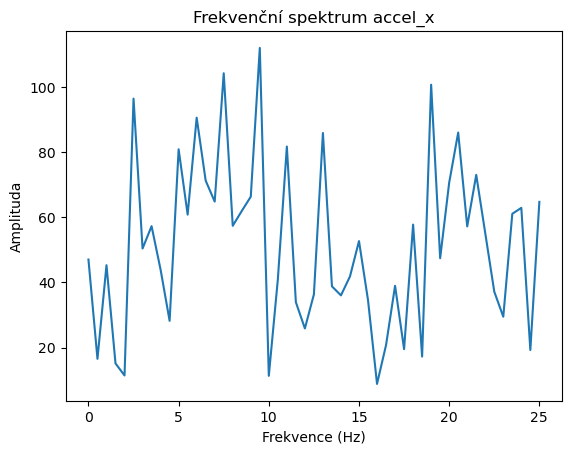

In [3]:
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

signal = df['accel_x'].values[:256]  # okno
fs = 50  # vzorkovací frekvence

yf = rfft(signal)
xf = rfftfreq(len(signal), 1 / fs)

dominant_freq = xf[np.argmax(np.abs(yf))]
print(f"Dominantní frekvence: {dominant_freq} Hz")

plt.plot(xf, np.abs(yf))
plt.title('Frekvenční spektrum accel_x')
plt.xlabel('Frekvence (Hz)')
plt.ylabel('Amplituda')
plt.show()


# MFCC – Mel-Frequency Cepstral Coefficients (pro zvuk)
MFCC jsou jedním z nejpoužívanějších typů příznaků pro rozpoznávání řeči a zvuku. Jedná se o komplexní transformaci signálu, která zachycuje jeho spektrální vlastnosti podle psychoakustických charakteristik lidského sluchu (mel-frekvence). Díky tomu jsou MFCC výborné pro identifikaci zvukových událostí, detekci klíčových slov nebo rozpoznávání hlasových povelů – což je často využíváno v TinyML aplikacích (např. "Hey Google" detekce). Přestože výpočet MFCC je náročnější než prostá FFT, dnes existují knihovny, které MFCC efektivně implementují i pro mikrokontroléry.


MFCC tvar: (13, 63)


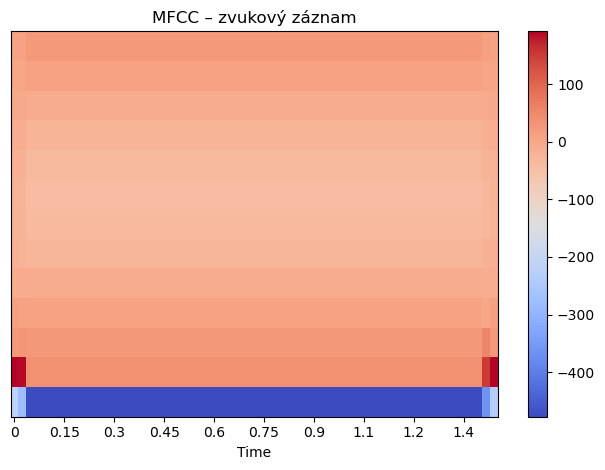

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load('audio_data.wav', sr=16000)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print("MFCC tvar:", mfccs.shape)

librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC – zvukový záznam')
plt.tight_layout()
plt.show()


# Augmentace zvuku pomocí šumu

In [5]:
import librosa
import soundfile as sf
import numpy as np

y, sr = librosa.load('audio_data.wav')

# augmentace přidáním šumu
noise = np.random.randn(len(y))
augmented_data = y + 0.005 * noise

sf.write('audio_data_augmented.wav', augmented_data, sr)


# MFCC s augmentovaným souborem

MFCC tvar: (13, 63)


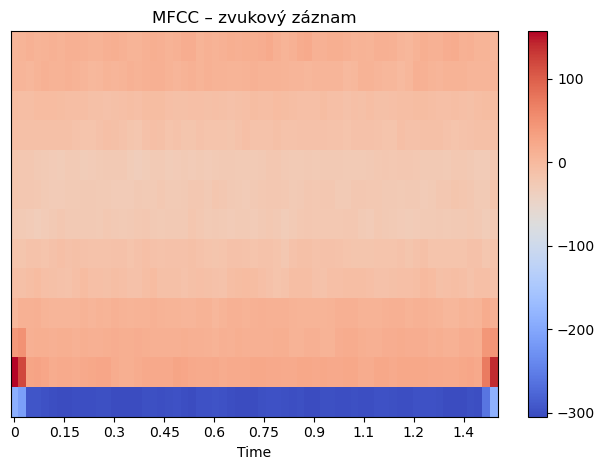

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load('audio_data_augmented.wav', sr=16000)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

print("MFCC tvar:", mfccs.shape)

librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC – zvukový záznam')
plt.tight_layout()
plt.show()

### Bag-of-Words a TF-IDF
Pokud pracujeme s textem (např. systémovými logy, klasifikací příkazů), musíme text převést do numerické podoby. Zde přichází na řadu extrakce příznaků jako Bag-of-Words (BoW) nebo TF-IDF. BoW vytvoří matici četností slov bez ohledu na jejich pořadí, zatímco TF-IDF zvýhodňuje slova, která jsou častá v daném dokumentu, ale vzácná jinde – čímž pomáhá odhalovat klíčová slova. Tento přístup je ideální pro klasifikaci textů, spam filtraci nebo kategorizaci zpráv z edge zařízení.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

documents = [
    "ESP32 S3 detects movement fast",
    "Motion detection using AI and ESP32",
    "Embedded ML is efficient on edge devices"
]

# Bag of Words
bow = CountVectorizer()
bow_features = bow.fit_transform(documents)
print("BoW features:\n", bow_features.toarray())

# TF-IDF
tfidf = TfidfVectorizer()
tfidf_features = tfidf.fit_transform(documents)
print("TF-IDF features:\n", tfidf_features.toarray())


BoW features:
 [[0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0]
 [1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0]]
TF-IDF features:
 [[0.         0.         0.         0.46735098 0.         0.
  0.         0.         0.35543247 0.46735098 0.         0.
  0.         0.46735098 0.         0.46735098 0.        ]
 [0.42339448 0.42339448 0.42339448 0.         0.         0.
  0.         0.         0.32200242 0.         0.         0.
  0.42339448 0.         0.         0.         0.42339448]
 [0.         0.         0.         0.         0.37796447 0.37796447
  0.37796447 0.37796447 0.         0.         0.37796447 0.37796447
  0.         0.         0.37796447 0.         0.        ]]
